<a href="https://colab.research.google.com/github/Ubaid-Manzoor/HandWritten-Digit-Recognization/blob/master/Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**N Layer Neural Network Using TenserFlow To Create A Model to Predict Hand Written Digits**

In [0]:
from tensorflow.python.framework import ops
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

np.random.seed(1)

**Transform the data into right Format**

In [0]:
mnist  = tf.keras.datasets.mnist

(X_train , y_train) , (X_test , y_test) = mnist.load_data()

In [0]:
y_train = tf.one_hot(y_train , len(np.unique(y_train)))
y_test = tf.one_hot(y_test , len(np.unique(y_test)))

In [408]:
#Flatten X
X_train = X_train.reshape(X_train.shape[0] , -1).T
X_test = X_test.reshape(X_test.shape[0] , -1).T

print(X_train.shape)
print(X_test.shape)

(784, 60000)
(784, 10000)


In [409]:
with tf.Session() as sess:
  y_train = sess.run(y_train).T
  y_test = sess.run(y_test).T
print(y_train.shape)
print(y_test.shape)

(10, 60000)
(10, 10000)


**All Useful Funtion To Create The Model**

1.   create_placeholder
2.   initialize_parameters_deep
3.   linear_forward
4.   linear_activation_forward
5.  L_model_forward
6.   compute_cost
7.   random_mini_batches
8.   model








In [0]:
def create_placeholders(n_x , n_y):
  """
  n_x -- num_px * num_px * 3(if RBG)
  n_y -- number of classes in This case (10 classes)
  """
  X = tf.placeholder(shape=[n_x,None] , dtype=tf.float32 , name="X")
  Y = tf.placeholder(shape=[n_y,None] , dtype=tf.float32 , name="Y")
  
  return X,Y

In [0]:
def initialize_parameters_deep(layer_dims):
  """
  layer_dims -- python list containing the dimension of each layer and is create manually as we are going to decide size of a layer \
                like [12222 , 20 , 7 , 4 , 1] 4layer model
  
  return:
  parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
  """
  
  np.random.seed(1)
  parameters = {}
  L = len(layer_dims) # number of layer in the network

  for l in range(1 , L):
    parameters['W' + str(l)] = tf.get_variable("W" + str(l) , [layer_dims[l] , 
                                               layer_dims[l-1]] , initializer = tf.contrib.layers.xavier_initializer(seed=1))
    parameters['b' + str(l)] = tf.get_variable("b" + str(l) , [layer_dims[l],1] , initializer=tf.zeros_initializer())
    
  return parameters

In [0]:
def linear_forward(A , W , b):
  Z = tf.add(tf.matmul(W,A),b)
  
  return Z

In [0]:
def linear_activation_forward(A_prev , W , b):
  Z = linear_forward(A_prev , W , b)
  A = tf.nn.relu(Z)
  
  return A

In [0]:
def L_model_forward(X , parameters):

  A = X
  L = len(parameters) / 2
  
  for l in range(1,L):
    A_prev = A
    A = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b' + str(l)])

  ZL = linear_forward(A , parameters['W' + str(L)] , parameters['b' + str(L)])

  return ZL

In [0]:
def compute_cost(Z3 , Y):
  # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
  logits = tf.transpose(Z3)
  labels = tf.transpose(Y)
  print(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
  
  return cost

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning

    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
#Define Dimension of all layers

layer_dims = [784 , 50 , 50 , 25 ,10] # 5 layer model

In [0]:
def model(X_train , Y_train , X_test , Y_test ,layer_dims ,learning_rate = 0.001 , num_epochs = 50 , 
          minibatch_size = 32 , print_cost = True):
  
  ops.reset_default_graph()
  tf.set_random_seed(1)
  #get n_x and n_y
  (n_x , m) = X_train.shape
  n_y = Y_train.shape[0]
  
  #create list to store the cost at each epochs
  costs = []
  #create placeholders
  X ,Y = create_placeholders(n_x , n_y)
  
  #initialize all weights and biaes 
  parameters = initialize_parameters_deep(layer_dims)
  
  #Forward propogate to calculate Z of layer L
  ZL = L_model_forward(X , parameters)
  
  #calculate Cost using ZL and Y
  cost = compute_cost(ZL , Y)
  
  #Minimize the cost using Adam optimizer
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  
  # initialize all the global variable here (W and b are global varibles)
  init = tf.global_variables_initializer()
  
  #Create a Session
  with tf.Session() as sess:
    #run init to initialize all variables
    sess.run(init)
    
    costs = []
    for epoch in range(num_epochs):
      epoch_cost = 0
      
      minibatches = random_mini_batches(X_train , Y_train , minibatch_size)
      
      for minibatch in minibatches:
        mini_X , mini_Y = minibatch

        _ , mini_cost = sess.run([optimizer , cost] , feed_dict={X:mini_X , Y:mini_Y})
        
        epoch_cost += mini_cost
      #if print_cost==True and (epoch % 10) == 0:
      print("Cost after epoch %i: %f" % (epoch , epoch_cost))
      costs.append(epoch_cost)
    parameters = sess.run(parameters)
    
    plt.plot(range(1,num_epochs+1) , costs)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.show()
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
    
    return parameters

Cost after epoch 0: 2317.135460
Cost after epoch 1: 584.782136
Cost after epoch 2: 403.950671
Cost after epoch 3: 328.984627
Cost after epoch 4: 281.504755
Cost after epoch 5: 240.939218
Cost after epoch 6: 217.775042
Cost after epoch 7: 193.882180
Cost after epoch 8: 177.400659
Cost after epoch 9: 169.902975
Cost after epoch 10: 156.233744
Cost after epoch 11: 144.910649
Cost after epoch 12: 137.502055
Cost after epoch 13: 133.151906
Cost after epoch 14: 122.673725
Cost after epoch 15: 118.968195
Cost after epoch 16: 113.851469
Cost after epoch 17: 112.576003
Cost after epoch 18: 104.484537
Cost after epoch 19: 110.292882
Cost after epoch 20: 97.029733
Cost after epoch 21: 95.963734
Cost after epoch 22: 98.341732
Cost after epoch 23: 94.987137
Cost after epoch 24: 88.266214
Cost after epoch 25: 86.953494
Cost after epoch 26: 89.606938
Cost after epoch 27: 87.701434
Cost after epoch 28: 83.929165
Cost after epoch 29: 77.702670
Cost after epoch 30: 77.784909
Cost after epoch 31: 81.0661

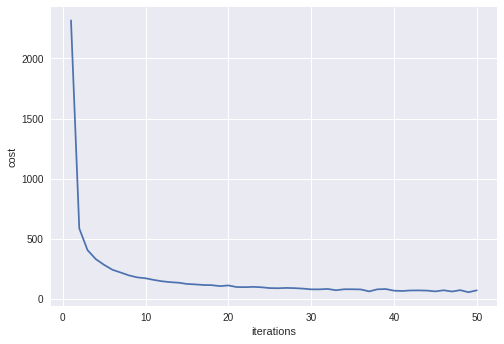

('Train Accuracy:', 0.9856833)
('Test Accuracy:', 0.9646)


In [442]:
parameters = model(X_train,y_train , X_test,y_test,layer_dims)